# Add Bands 1 and 2 to database

The goal of this notebook is to add estimates of bands 1 and 2 to the database. I want to keep the original database code intact, so doing this in a separate notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
import astropy.units as u
from importlib import reload
import wsu_plots
import wsu_db
import large_cubes
import pickle

## reading in the data

In [2]:
# fix up custom units
#gvis = u.def_unit('Gvis',namespace=globals())
#u.add_enabled_units([gvis])

In [3]:
result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20231012.ecsv')
result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20231012.ecsv')

In [4]:
wsu_all = vstack([result_c7_mous,result_c8_mous])

In [5]:
wsu_all.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nc

In [6]:
wsu_all['weights_all'] = wsu_all['time_tot']/np.sum(wsu_all['time_tot'])

## creating estimated database

In [7]:
reload(wsu_db)
# I need to do 10% total: 5% each for band 1 and lower end of band 2). probably should output the amount of time removed.
(new_db_12m, time_12m) = wsu_db.remove_projects(wsu_all,array='12m',time_frac=0.1)
#  I need to do 6% total: 3% each for band 1 and lower end of Band 2).
(new_db_12m_7m,time_7m) = wsu_db.remove_projects(new_db_12m,array='7m',time_frac=0.06)

---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 351
New number of MOUSes: 4849


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 523.4174399999997 h
---
---
Total number of MOUSes: 4849
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 137
New number of MOUSes: 4712


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 240.38027999999997 h
---


In [8]:
reload(wsu_db)
db_update_band1_12m = wsu_db.add_bands(new_db_12m_7m, array='12m', band=1.0,total_time=time_12m.to('hr')/2.0)
db_update_band2_12m = wsu_db.add_bands(new_db_12m_7m, array='12m', band=2.0,total_time=time_12m.to('hr')/2.0)

In [9]:
reload(wsu_db)
db_update_band1_7m = wsu_db.add_bands(new_db_12m_7m, array='7m', band=1.0,total_time=time_7m.to('hr')/2.0)
db_update_band2_7m = wsu_db.add_bands(new_db_12m_7m, array='7m', band=2.0,total_time=time_7m.to('hr')/2.0)

In [10]:
# combine everything
wsu_all_band1_band2 = vstack([new_db_12m_7m, 
                              db_update_band1_12m, db_update_band2_12m, 
                              db_update_band1_7m, db_update_band2_7m])

In [11]:
wsu_all_band1_band2.write('data/wsu_datarates_mit_per_mous_band12_20231012.ecsv',overwrite=True)

## checking on the individual results

Text(0.5, 0, 'velocity resolution (km/s)')

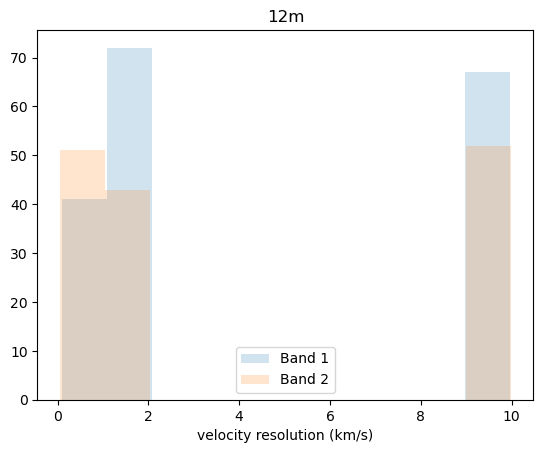

In [12]:
plt.hist(db_update_band1_12m['wsu_velres_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_velres_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('12m')
plt.xlabel('velocity resolution (km/s)')

Text(0.5, 0, 'nchan per spw')

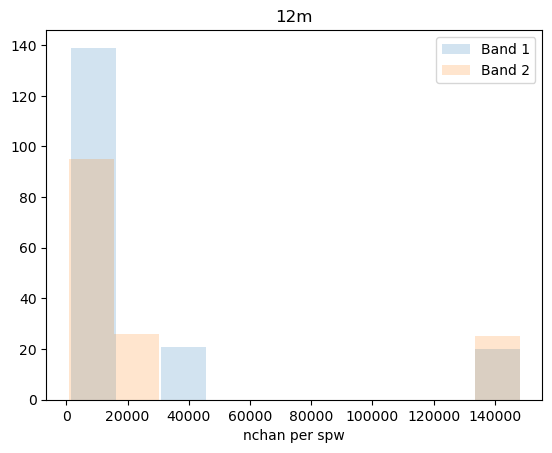

In [13]:
plt.hist(db_update_band1_12m['wsu_nchan_spw_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_nchan_spw_stepped2'].value,label='Band 2',alpha=0.2)
plt.title('12m')
plt.legend()
plt.xlabel('nchan per spw')

In [14]:
np.nanmax(db_update_band1_12m['wsu_nchan_spw_stepped2'])

<Quantity 148148.>

In [15]:
100*14880

1488000

In [16]:
2e9/13.5e3

148148.14814814815

In [17]:
# this gives total BW
14880*13.5

200880.0

In [18]:
# but usable is 200MHz, so have fewer channes.
200.00e6/13.5e3

14814.814814814816

In [19]:
14815*10

148150

The above is within 2 of my max, so good enough.
Based on the above calculations, I think everything is happening properly. I'm just assuming that all the SPWs are contiguous, so the "extra" channels in the 0.88 MHz aren't used.

Text(0.5, 0, 'velocity resolution (km/s)')

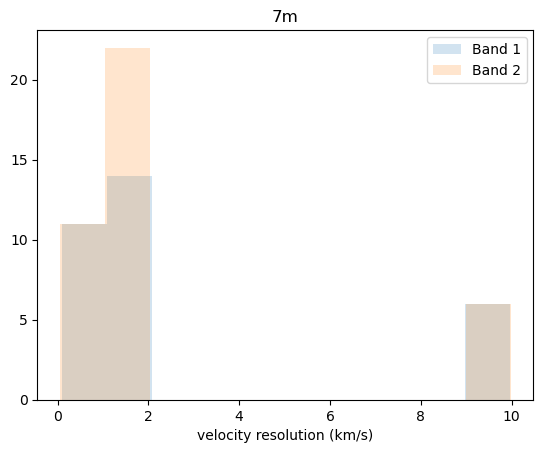

In [20]:
plt.hist(db_update_band1_7m['wsu_velres_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_7m['wsu_velres_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('velocity resolution (km/s)')

Text(0.5, 0, 'nchan per spw')

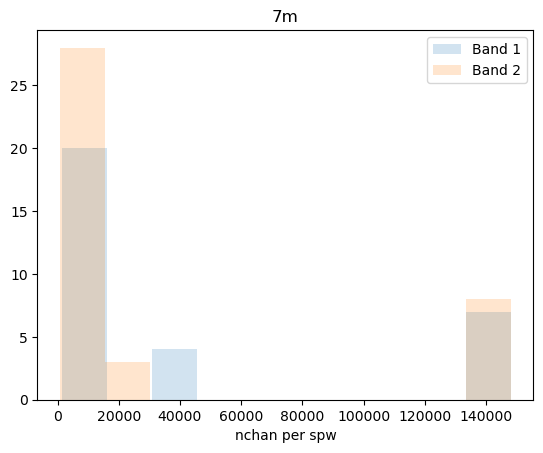

In [21]:
plt.hist(db_update_band1_7m['wsu_nchan_spw_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_7m['wsu_nchan_spw_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('nchan per spw')

In [22]:
db_update_band1_7m.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nchan_agg_stepped_later_4x','wsu_nchan_agg_stepped2_early','wsu_nchan_agg_stepped2_later_2x','wsu_nchan_agg_stepped2_later_4x','wsu_frac

Text(0.5, 0, 'required system performance (PFLOP/s)')

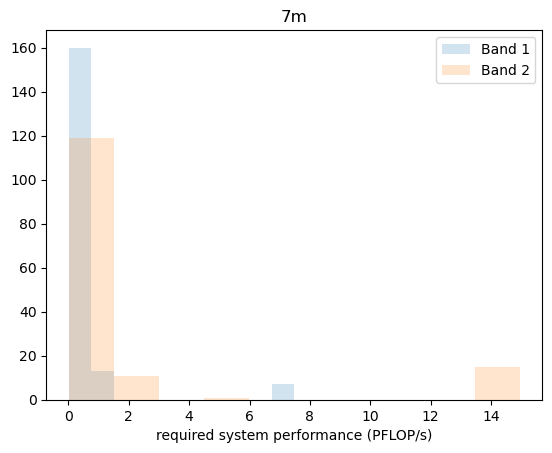

In [23]:
plt.hist(db_update_band1_12m['wsu_sysperf_later_4x_stepped2_typical_aprojonly'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_sysperf_later_4x_stepped2_typical_aprojonly'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('required system performance (PFLOP/s)')

Text(0.5, 0, 'required system performance (PFLOP/s)')

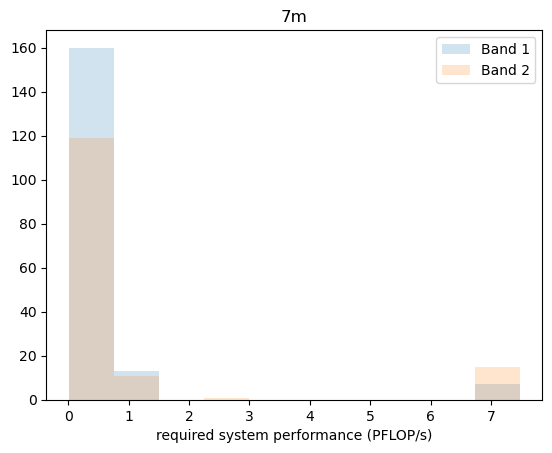

In [24]:
plt.hist(db_update_band1_12m['wsu_sysperf_early_stepped2_typical_aprojonly'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_sysperf_early_stepped2_typical_aprojonly'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('required system performance (PFLOP/s)')

## Checking on the combined results

In [25]:
len(wsu_all_band1_band2)

5108

In [26]:
np.nansum(wsu_all_band1_band2['time_tot']).to('hr')

<Quantity 9193.34168 h>

In [27]:
np.nansum(wsu_all['time_tot']).to('hr')

<Quantity 9181.3294 h>

In [28]:
len(wsu_all_band1_band2)

5108

In [29]:
len(wsu_all)

5200

In [30]:
wsu_all['weights_all'] = wsu_all['time_tot']/np.sum(wsu_all['time_tot'])

In [31]:
wsu_all_band1_band2['weights_all'] = wsu_all_band1_band2['time_tot']/np.sum(wsu_all_band1_band2['time_tot'])

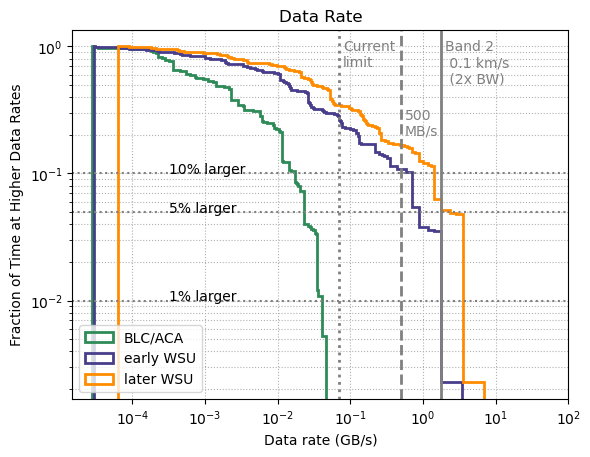

In [32]:
reload(wsu_plots)
wsu_plots.plot_datarate_comparison(wsu_all,
                                   add_band2_specscan=True)

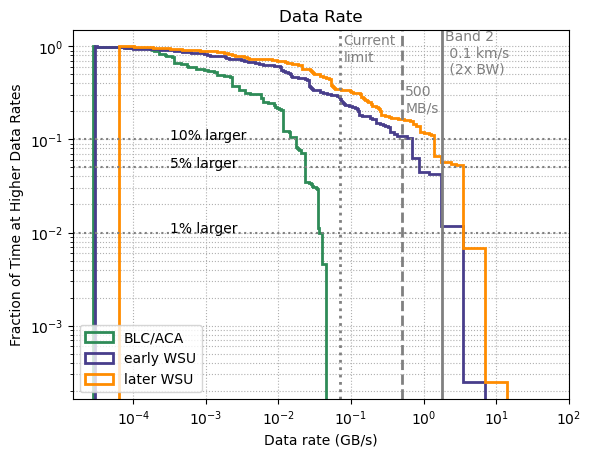

In [33]:
reload(wsu_plots)
wsu_plots.plot_datarate_comparison(wsu_all_band1_band2,
                                   add_band2_specscan=True)

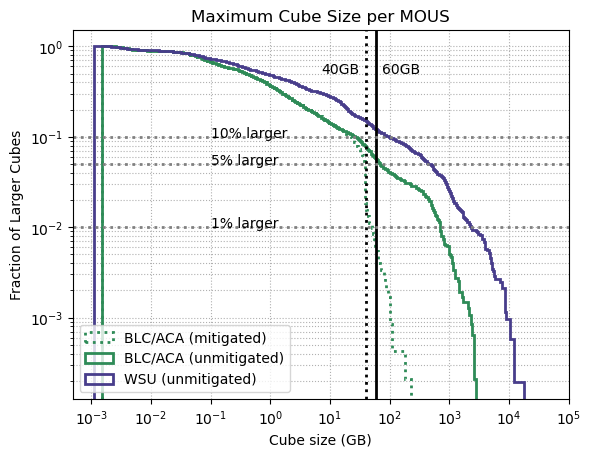

In [34]:
reload(wsu_plots)
wsu_plots.plot_cubesize_comparison(wsu_all,
                                   plot_title='Maximum Cube Size per MOUS')

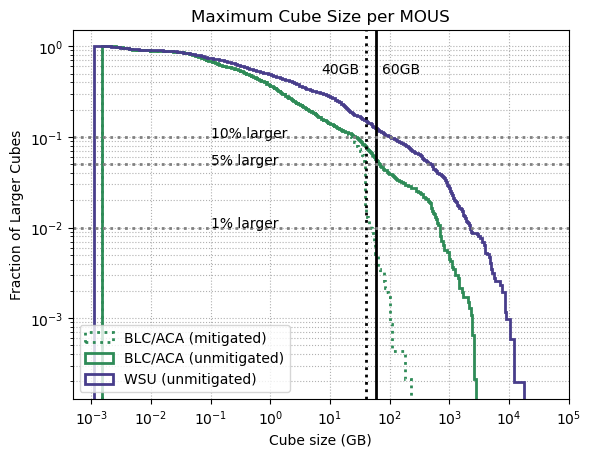

In [35]:
reload(wsu_plots)
wsu_plots.plot_cubesize_comparison(wsu_all_band1_band2,
                                   plot_title='Maximum Cube Size per MOUS')

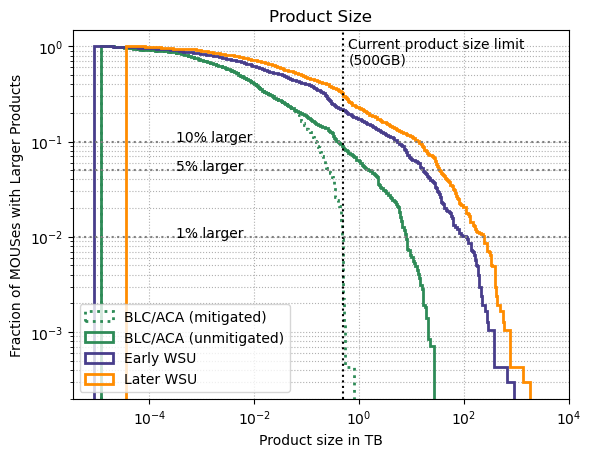

In [36]:
reload(wsu_plots)
wsu_plots.plot_productsize_comparison(wsu_all)

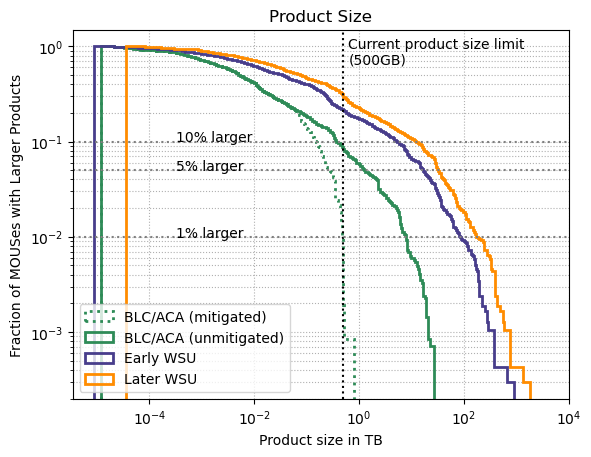

In [37]:
reload(wsu_plots)
wsu_plots.plot_productsize_comparison(wsu_all_band1_band2)

maximum ratio
1051.6597155555555
median ratio
3.64966853984339


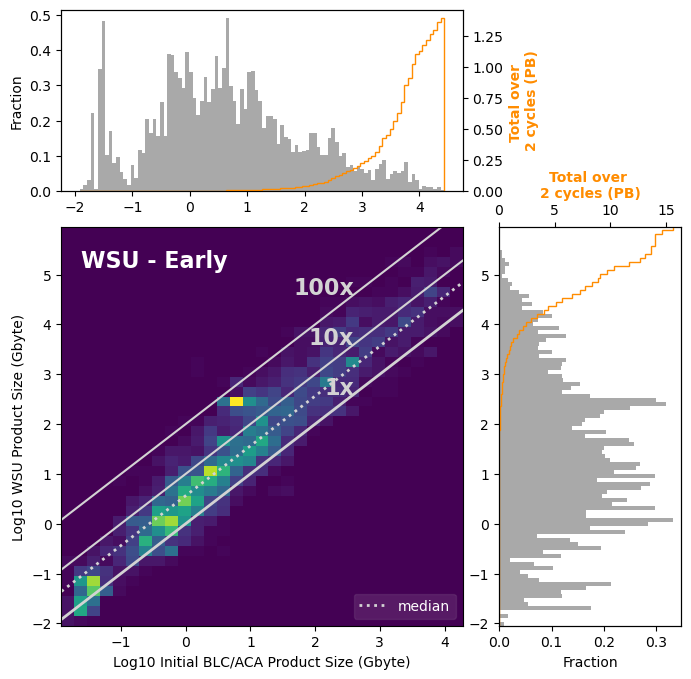

In [38]:
reload(wsu_plots)
wsu_plots.productsize_comparison_hist_plot(wsu_all,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

maximum ratio
1051.6597155555555
median ratio
3.885359297142857


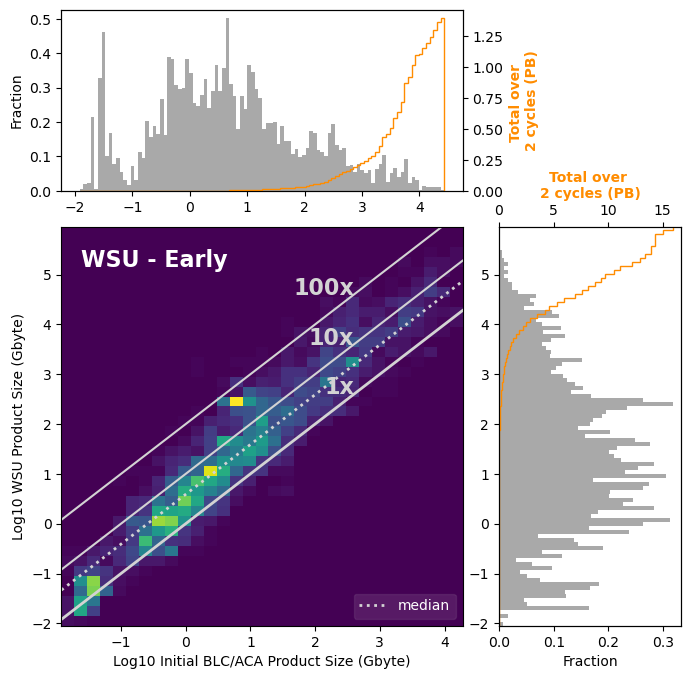

In [39]:
reload(wsu_plots)
wsu_plots.productsize_comparison_hist_plot(wsu_all_band1_band2,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

median ratio
3.64966853984339
max ratio
1051.6597155555555
log10 (peak)
0.24058630490303778
peak
1.7401484736122035


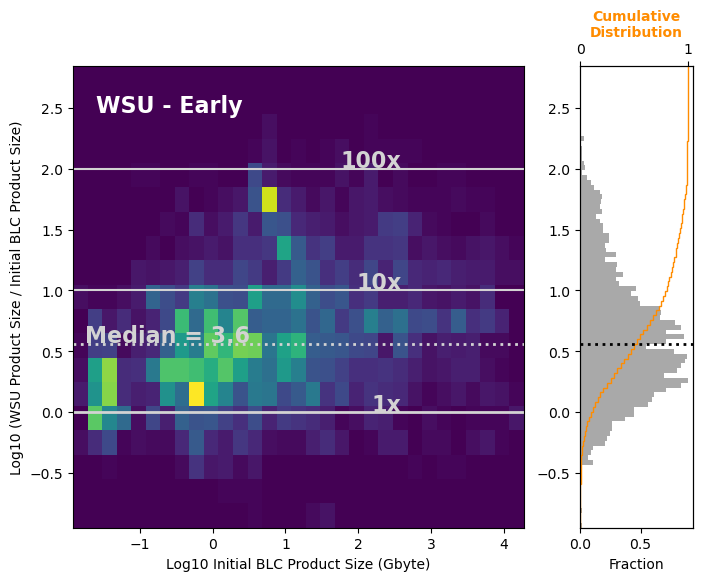

In [40]:
reload(wsu_plots)
wsu_plots.productsize_ratio_hist_plot(wsu_all,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

median ratio
3.885359297142857
max ratio
1051.6597155555555
log10 (peak)
0.6006652613650727
peak
3.9871746675155064


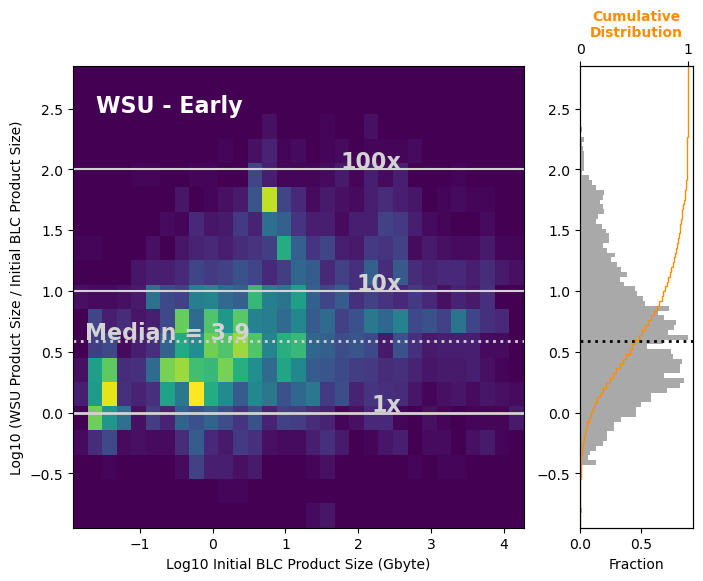

In [41]:
reload(wsu_plots)
wsu_plots.productsize_ratio_hist_plot(wsu_all_band1_band2,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

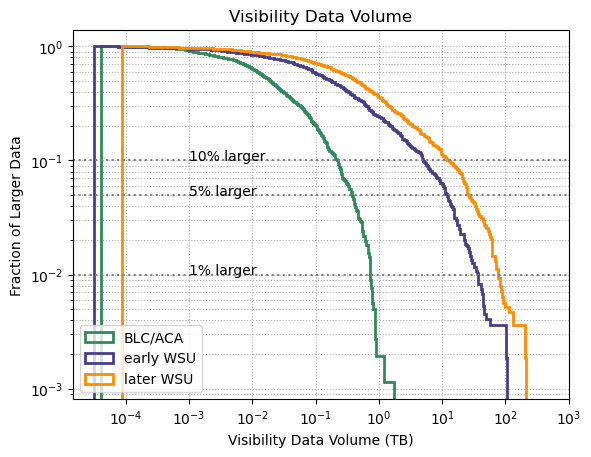

In [42]:
reload(wsu_plots)
wsu_plots.plot_datavol_comparison(wsu_all)

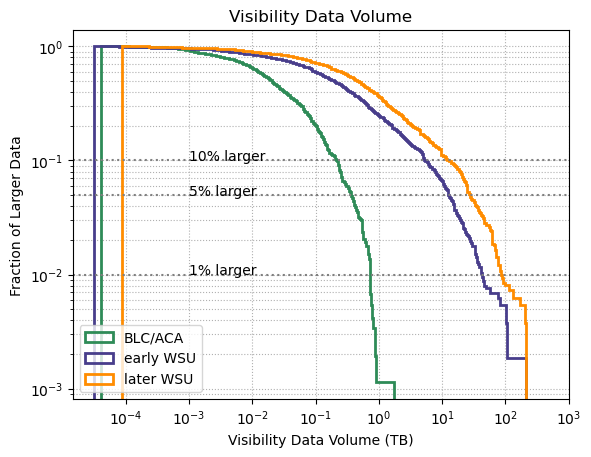

In [43]:
reload(wsu_plots)
wsu_plots.plot_datavol_comparison(wsu_all_band1_band2)

Median Ratio
7.149707031249999
Max Ratio
1736.109375


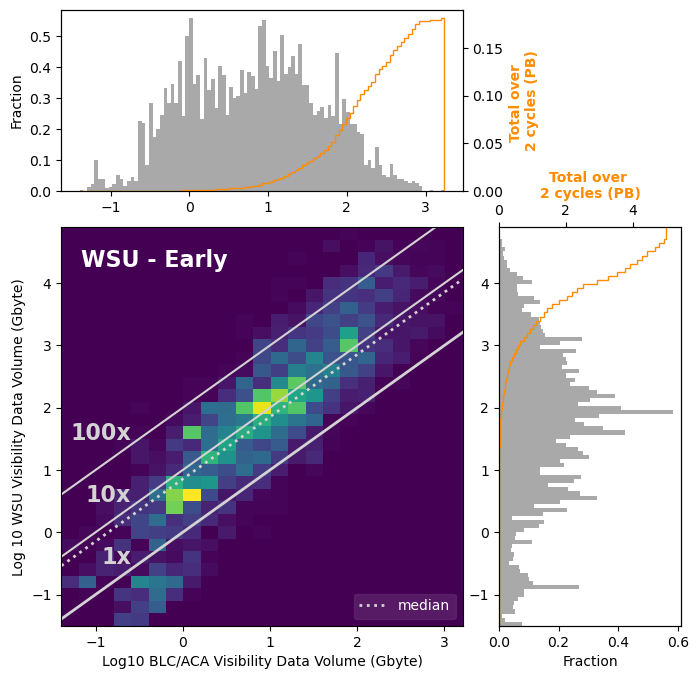

In [44]:
reload(wsu_plots)
wsu_plots.visibility_size_comparison_hist_plot(wsu_all,stage='early',plot_title='WSU - Early')

Median Ratio
8.203125000000002
Max Ratio
3472.21875


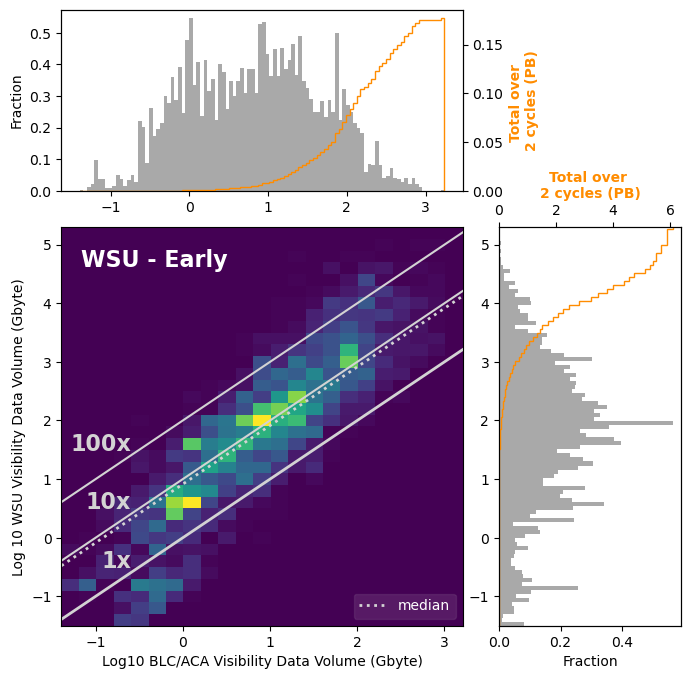

In [45]:
reload(wsu_plots)
wsu_plots.visibility_size_comparison_hist_plot(wsu_all_band1_band2,stage='early',plot_title='WSU - Early')

## Generating sample

In [46]:
## ~24 min to generate 50 samples on laptop.
reload(wsu_db)
wsu_db.generate_db_realizations(wsu_all, outDir='data/sample_band1_band2',
                                filename='wsu_datarates_mit_per_mous_band12_20231012',
                                frac_12m=0.1, frac_7m=0.06, n=50)

-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_000.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 372
New number of MOUSes: 4828


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 524.2333600000001 h
---
---
Total number of MOUSes: 4828
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 112
New number of MOUSes: 4716


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 238.98700000000005 h
---
-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_001.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 396
New number of MOUSes: 4804


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 523.3983999999999 h
---
---
Total number of MOUSes: 4804
Total number of MOUSes meeting

-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_014.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 363
New number of MOUSes: 4837


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 523.0797600000002 h
---
---
Total number of MOUSes: 4837
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 133
New number of MOUSes: 4704


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 237.45876000000004 h
---
-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_015.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 359
New number of MOUSes: 4841


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 522.9391999999997 h
---
---
Total number of MOUSes: 4841
Total number of MOUSes meeting

-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_028.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 361
New number of MOUSes: 4839


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 523.92088 h
---
---
Total number of MOUSes: 4839
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 117
New number of MOUSes: 4722


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 247.08375999999987 h
---
-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_029.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 339
New number of MOUSes: 4861


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 524.9143200000001 h
---
---
Total number of MOUSes: 4861
Total number of MOUSes meeting the cri

-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_042.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 332
New number of MOUSes: 4868


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 522.9868 h
---
---
Total number of MOUSes: 4868
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 78
New number of MOUSes: 4790


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 250.18839999999994 h
---
-------------
data/sample_band1_band2/wsu_datarates_mit_per_mous_band12_20231012_043.ecsv
---
Total number of MOUSes: 5200
Total number of MOUSes meeting the criteria: 2826
Number of MOUSes removed: 322
New number of MOUSes: 4878


Total time: 5227.821893333333 h
Time to be replaced: 522.7821893333333 h
Time replaced: 523.2696 h
---
---
Total number of MOUSes: 4878
Total number of MOUSes meeting the criteria: 1493

In [47]:
wsu_all.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nc

## Measuring aggregate sample properties

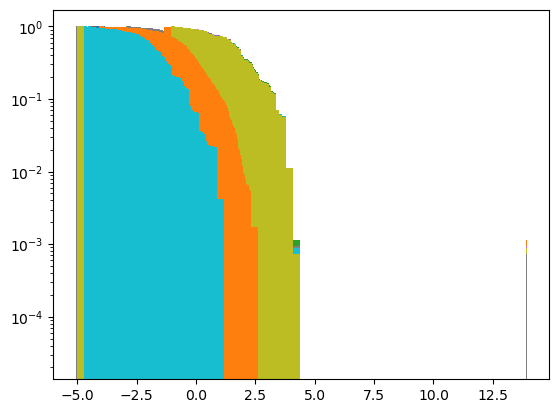

In [48]:
reload(wsu_db)
myresults = wsu_db.calculate_dist(outDir='data/sample_band1_band2',
                                  filename='wsu_datarates_mit_per_mous_band12_20231012',
                                  nbins=500)

In [49]:
# save results
import os
pickle.dump(myresults,open(os.path.join('data/sample_band1_band2',
                                        'wsu_datarates_mit_per_mous_band12_20231012'+"_agg.pkl"),'wb'))

In [50]:
reload(wsu_db)
mystats = wsu_db.calc_wsu_stats_allsamples(outDir='data/sample_band1_band2',
                                  filename='wsu_datarates_mit_per_mous_band12_20231012')

/Users/akepley/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [51]:
# save results
import os
pickle.dump(mystats,open(os.path.join('data/sample_band1_band2',
                                        'wsu_datarates_mit_per_mous_band12_20231012'+"_stats.pkl"),'wb'))

In [52]:
mystats.keys()

dict_keys(['blc_nchan_agg', 'wsu_nchan_agg_stepped2_early', 'wsu_nchan_agg_stepped2_later_4x', 'wsu_cubesize_stepped2', 'wsu_productsize_early_stepped2', 'wsu_datarate_early_stepped2_typical', 'wsu_datavol_early_stepped2_typical_target_tot', 'wsu_datavol_early_stepped2_typical_cal', 'wsu_datavol_early_stepped2_typical_total', 'blc_datarate_typical', 'blc_datavol_typical_target_tot', 'blc_datavol_typical_cal', 'blc_datavol_typical_total', 'wsu_productsize_later_4x_stepped2', 'wsu_datarate_later_4x_stepped2_typical', 'wsu_datavol_later_4x_stepped2_typical_target_tot', 'wsu_datavol_later_4x_stepped2_typical_cal', 'wsu_datavol_later_4x_stepped2_typical_total', 'blc_cubesize', 'blc_productsize', 'blc_sysperf_typical_aprojonly', 'wsu_sysperf_early_stepped2_typical_aprojonly', 'wsu_sysperf_later_2x_stepped2_typical_aprojonly', 'wsu_sysperf_later_4x_stepped2_typical_aprojonly'])

In [80]:
reload(wsu_db)
wsu_db.make_wsu_stats_table_newstats_datarate(mystats,fileout='tables/wsu_datarate_summary.tex')

In [81]:
reload(wsu_db)
wsu_db.make_wsu_stats_table_newstats_datavol(mystats,fileout='tables/wsu_datavol_summary.tex')

In [82]:
reload(wsu_db)
wsu_db.make_blc_stats_table_newstats_datarate(mystats,fileout='tables/blc_datarate_summary.tex')

In [83]:
reload(wsu_db)
wsu_db.make_blc_stats_table_newstats_datavol(mystats,fileout='tables/blc_datavol_summary.tex')

In [ ]:
mystats.keys()

In [ ]:
mystats['wsu_productsize_early_stepped2']['12m']

In [ ]:
idx = (wsu_all['array'] == '12m')
wsu_all['wsu_productsize_later_4x_stepped2'][idx].to('TB')

In [ ]:
idx = (wsu_all_band1_band2['band'] == 1) & (wsu_all_band1_band2['L80'] > 6.0*u.km)
wsu_all_band1_band2[idx]['mous','band','L80','wsu_nchan_spw_stepped2','wsu_velres_stepped2']

In [ ]:
np.max(wsu_all_band1_band2['L80'])

In [ ]:
test = np.sqrt(2.0*wsu_all_band1_band2['s_resolution'].value/206265.0)*206265 ## units are arcsec here.

In [ ]:
idx = wsu_all_band1_band2['s_fov'].to('arcsec').value > test

In [ ]:
wsu_all_band1_band2[idx]['proposal_id','mous','band','mosaic','L80','s_fov']

So only 11 are greater than the test value. They are all form the infamous Catelyn Casey project where she is doing the blank strips of 30arcmin or so but really narrow. So I think that none of these are true cases where you need w-project.

In [ ]:
wsu_all.columns

In [ ]:
myresults.keys()

In [ ]:
myresults['wsu_nvis_early_stepped2_typical_total'].keys()

In [ ]:
orig, orig_bins, orig_patches = plt.hist(np.log10(wsu_all['wsu_nvis_later_4x_stepped2_typical_total'].value),
                                         cumulative=-1,density=True, log=True,bins=myresults['wsu_nvis_later_4x_stepped2_typical_total']['bins'])

In [ ]:
## magic needed to get last bin filled in: cut off first bin, then do step="pre"
quantity = 'wsu_nvis_later_4x_stepped2_typical_total'
plt.fill_between(myresults[quantity]['bins'][1:],myresults[quantity]['min'],y2=myresults[quantity]['max'], 
                 step="pre",alpha=0.4) 

plt.stairs(myresults[quantity]['median'],myresults[quantity]['bins'], label='median',linewidth=2)

plt.stairs(orig,myresults[quantity]['bins'],label='orig',linewidth=2)
plt.yscale('log')
plt.legend()
#plt.hist(np.log10(wsu_all['wsu_datarate_early_stepped2_typical'].value),cumulative=-1,density=True, 
#         log=True,bins=myresults['bins'],histtype='stepfilled')
plt.xlabel('log10 data rate')
plt.ylabel('number')


The above shows that the initial change in the data rates is a small bump at the middling large data rates, and then at the high end. So my original estimates weren't that bad. Also makes sense because band 1 and 2 are only a small fraction of the data cases by design.

In [ ]:
myresults['wsu_cubesize_stepped2'].keys()